## U-Net on Ellipses

In [1]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import radon, iradon
from torch.utils.data import DataLoader, TensorDataset,random_split
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import os

In [2]:
reconstructed_images = torch.load('/content/drive/MyDrive/MTP-dataset/reconstructed_cnn2.pt')
ground_truth_images = torch.load('/content/drive/MyDrive/MTP-dataset/ground_truth_cnn.pt')
ground_truth_images = ground_truth_images.view(-1,1,128,128)
reconstructed_images = reconstructed_images.view(-1,1,128,128)
dataset = TensorDataset(reconstructed_images ,ground_truth_images)

# Split the dataset into train and test sets
train_size = int(0.8 * len(dataset))  # 80% for training
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
print(len(train_dataset))
print(len(test_dataset))
# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True,drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False,drop_last=True)

3174
794


In [3]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 12.5 MB/s eta 0:00:00


In [4]:
import torch
import torch.nn as nn

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.inc = DoubleConv(n_channels, 64)
        self.down1 = nn.MaxPool2d(2)
        self.down2 = DoubleConv(64, 128)
        self.up1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.up2 = DoubleConv(128, 64)
        self.outc = nn.Conv2d(64, n_classes, kernel_size=1)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.up1(x3)
        x5 = torch.cat([x4, x1], dim=1)
        x6 = self.up2(x5)
        logits = self.outc(x6)
        return logits


In [5]:
from tqdm import tqdm
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet(1, 1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()
training_losses = []
# Training loop
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    for data in tqdm(train_loader):
        inputs, targets = data
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs.float())
        loss = criterion(outputs, targets.float())
        loss.backward()
        optimizer.step()
    training_losses.append(loss)

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.6f}')
torch.save(model.state_dict(), 'unetonmnist4000.pth')

100%|██████████| 49/49 [00:23<00:00,  2.12it/s]


Epoch [1/20], Loss: 0.004063


100%|██████████| 49/49 [00:15<00:00,  3.18it/s]


Epoch [2/20], Loss: 0.004741


100%|██████████| 49/49 [00:15<00:00,  3.23it/s]


Epoch [3/20], Loss: 0.003054


100%|██████████| 49/49 [00:15<00:00,  3.24it/s]


Epoch [4/20], Loss: 0.001287


100%|██████████| 49/49 [00:15<00:00,  3.23it/s]


Epoch [5/20], Loss: 0.001114


100%|██████████| 49/49 [00:15<00:00,  3.22it/s]


Epoch [6/20], Loss: 0.001843


100%|██████████| 49/49 [00:15<00:00,  3.22it/s]


Epoch [7/20], Loss: 0.002303


100%|██████████| 49/49 [00:15<00:00,  3.23it/s]


Epoch [8/20], Loss: 0.000858


100%|██████████| 49/49 [00:15<00:00,  3.24it/s]


Epoch [9/20], Loss: 0.001111


100%|██████████| 49/49 [00:15<00:00,  3.22it/s]


Epoch [10/20], Loss: 0.000877


100%|██████████| 49/49 [00:15<00:00,  3.18it/s]


Epoch [11/20], Loss: 0.000908


100%|██████████| 49/49 [00:15<00:00,  3.19it/s]


Epoch [12/20], Loss: 0.000723


100%|██████████| 49/49 [00:15<00:00,  3.21it/s]


Epoch [13/20], Loss: 0.000457


100%|██████████| 49/49 [00:15<00:00,  3.21it/s]


Epoch [14/20], Loss: 0.001447


100%|██████████| 49/49 [00:15<00:00,  3.19it/s]


Epoch [15/20], Loss: 0.001455


100%|██████████| 49/49 [00:15<00:00,  3.19it/s]


Epoch [16/20], Loss: 0.000599


100%|██████████| 49/49 [00:15<00:00,  3.19it/s]


Epoch [17/20], Loss: 0.000494


100%|██████████| 49/49 [00:15<00:00,  3.19it/s]


Epoch [18/20], Loss: 0.000421


100%|██████████| 49/49 [00:15<00:00,  3.19it/s]


Epoch [19/20], Loss: 0.001812


100%|██████████| 49/49 [00:15<00:00,  3.19it/s]


Epoch [20/20], Loss: 0.001129


In [6]:
training_loss_object = training_losses
training_loss = []
for x in training_loss_object:
  training_loss.append(x.item())
print(training_loss)

[0.004062524065375328, 0.0047406526282429695, 0.0030535985715687275, 0.0012868719641119242, 0.0011142833391204476, 0.0018432963406667113, 0.0023030757438391447, 0.0008582528098486364, 0.0011112373322248459, 0.0008766493992879987, 0.000907524605281651, 0.0007228803006000817, 0.00045684934593737125, 0.0014470252208411694, 0.0014551752246916294, 0.0005989198107272387, 0.0004943656385876238, 0.0004211741324979812, 0.0018119520973414183, 0.0011286174412816763]


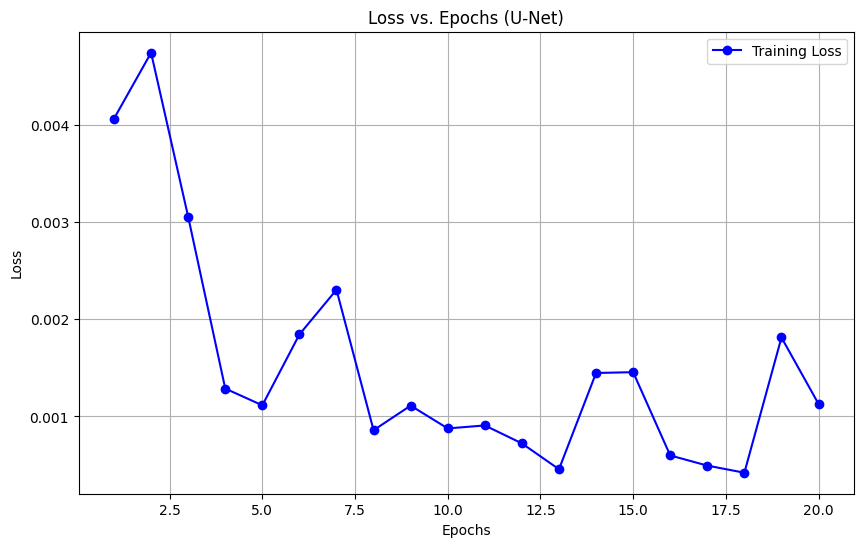

In [7]:
epochs = np.arange(1, num_epochs + 1)
plt.figure(figsize=(10, 6))
plt.plot(epochs, training_loss, marker='o', linestyle='-', color='b', label='Training Loss')
plt.title('Loss vs. Epochs (U-Net)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

Average SSIM: 0.9625
Average PSNR: 34.4781
Average SSIM: 0.8895
Average PSNR: 26.4674


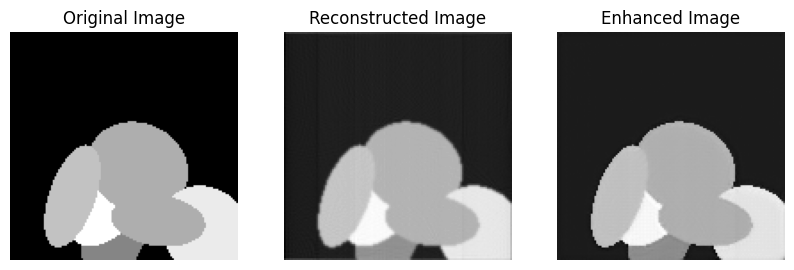

In [11]:
import numpy as np
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

# Function to calculate SSIM for a batch of images
def batch_ssim(enhanced_images, ground_truth_images):
    ssim_scores = []
    for i in range(enhanced_images.size(0)):
        enhanced_np = enhanced_images[i].cpu().squeeze().numpy()
        gt_np = ground_truth_images[i].cpu().squeeze().numpy()
        score = ssim(enhanced_np, gt_np, data_range=gt_np.max() - gt_np.min())
        ssim_scores.append(score)
    return np.mean(ssim_scores)

# Function to calculate PSNR for a batch of images
def batch_psnr(enhanced_images, ground_truth_images):
    psnr_scores = []
    for i in range(enhanced_images.size(0)):
        enhanced_np = enhanced_images[i].cpu().squeeze().numpy()
        gt_np = ground_truth_images[i].cpu().squeeze().numpy()
        score = psnr(enhanced_np, gt_np, data_range=gt_np.max() - gt_np.min())
        psnr_scores.append(score)
    return np.mean(psnr_scores)

# Evaluate the model and calculate SSIM and PSNR
model.eval()
all_ssim_scores = []
all_psnr_scores = []
recon_ssim = []
recon_psnr = []
printed = False
with torch.no_grad():
    for batch_reconstructed_images, batch_ground_truth_images in test_loader:
        batch_reconstructed_images = batch_reconstructed_images.to(device).float()
        batch_ground_truth_images = batch_ground_truth_images.to(device).float()
        enhanced_images = model(batch_reconstructed_images)
        if printed == False:
          printed = True
          plt.figure(figsize=(10,5))
          plt.subplot(131)
          plt.axis("off")
          plt.title("Original Image")
          plt.imshow(batch_ground_truth_images[0][0].cpu(),cmap='gray')
          plt.subplot(132)
          plt.axis("off")
          plt.title("Reconstructed Image")
          plt.imshow(batch_reconstructed_images[0][0].cpu(),cmap='gray')
          plt.subplot(133)
          plt.axis("off")
          plt.title("Enhanced Image")
          plt.imshow(enhanced_images[0][0].cpu(),cmap='gray')
        all_ssim_scores.append(batch_ssim(enhanced_images, batch_ground_truth_images))
        all_psnr_scores.append(batch_psnr(enhanced_images, batch_ground_truth_images))

        recon_ssim.append(batch_ssim(batch_reconstructed_images, batch_ground_truth_images))
        recon_psnr.append(batch_psnr(batch_reconstructed_images, batch_ground_truth_images))
        # break

# Calculate average SSIM and PSNR
avg_ssim = np.mean(all_ssim_scores)
avg_psnr = np.mean(all_psnr_scores)
rec_ssim = np.mean(recon_ssim)
rec_psnr = np.mean(recon_psnr)
print(f'Average SSIM: {avg_ssim:.4f}')
print(f'Average PSNR: {avg_psnr:.4f}')
print(f'Average SSIM: {rec_ssim:.4f}')
print(f'Average PSNR: {rec_psnr:.4f}')



In [ ]:
total_params = sum(p.numel() for p in model.parameters())
print("Total number of parameters: ", total_params)

Total number of parameters:  403649


In [ ]:
print(model)

UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (down2): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=Tr